In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from datetime import datetime
import time

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost

# Market Price Estimation — BMW cars' auctions.

### EDA

In [2]:
df_raw = pd.read_csv("auctions.csv")

In [3]:
df = df_raw.copy()

In [4]:
columns = ['maker_key', 'model_key', 'fuel', 'paint_color', 'car_type']

In [5]:
def description(columns):
    result = []
    for column in columns:
        result.append(f"There are {df[column].nunique()} different {column}s.\n")
    return result

descriptions = description(columns)
for desc in descriptions:
    print(desc)

There are 1 different maker_keys.

There are 75 different model_keys.

There are 4 different fuels.

There are 10 different paint_colors.

There are 8 different car_types.



In [6]:
mets = ['engine_power', 'model_key', 'fuel', 'paint_color', 'car_type']

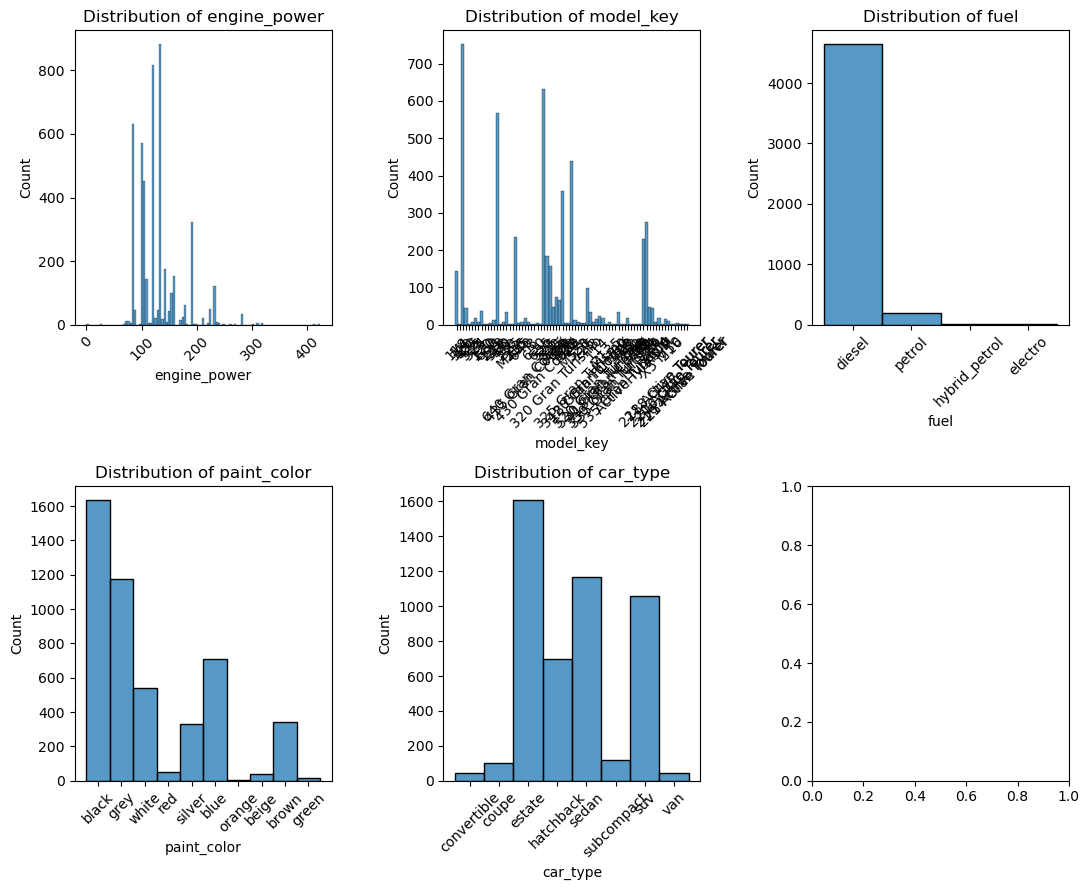

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 9))

axes = axes.flatten()

for i, metric in enumerate(mets):
    ax = axes[i]
    sns.histplot(data=df, x=metric, ax=ax)
    ax.set_title(f"Distribution of {metric}")
    ax.tick_params(axis='x', rotation=45)  # Set x-axis tick labels rotation

plt.tight_layout()
plt.show()

In [8]:
df_1 = df_raw.copy()
df_1["mileage_clipped"]= df_1['mileage'].clip(upper=300000)
df_1["price_clipped"]= df["price"].clip(upper=50000)

In [9]:
mets_1 = ['mileage_clipped', 'price_clipped']

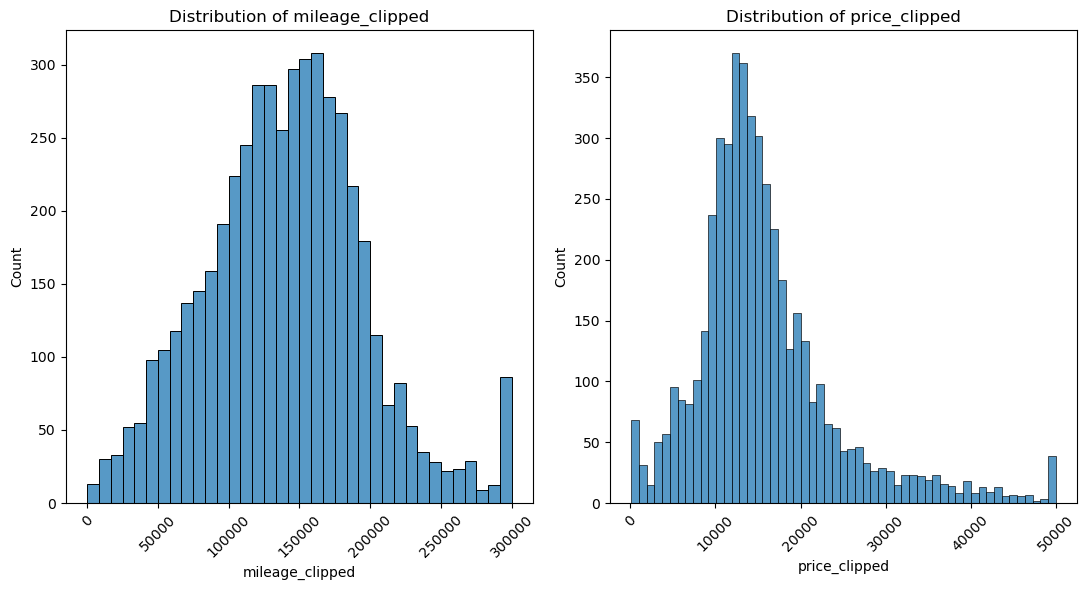

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))

axes = axes.flatten()

for i, metric in enumerate(mets_1):
    ax = axes[i]
    sns.histplot(data=df_1, x=metric, ax=ax)
    ax.set_title(f"Distribution of {metric}")
    ax.tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

In [11]:
expensive_cars = df[df['price'] > 50000]

In [12]:
print(f"There are {len(expensive_cars)} expensive cars (more than 50k dollars)")

There are 32 expensive cars (more than 50k dollars)


In [13]:
high_milers = df[df['mileage'] > 300000]

In [14]:
print(f"There are {len(high_milers)} high milers (more than 300k miles)")

There are 76 high milers (more than 300k miles)


In [15]:
print('The most expensive car costs ' + str(df["price"].max()) + ' dollars')

The most expensive car costs 178500 dollars


In [16]:
print('The oldest car is from ' + str(df['registration_date'].min()))

The oldest car is from 1/1/1994


In [17]:
print('The most recent car is from ' + str(df['registration_date'].max()))

The most recent car is from 9/1/2016


In [18]:
f"There have been {df['sold_at'].nunique()} different auction dates, all the same week."

'There have been 9 different auction dates, all the same week.'

In [19]:
sold_at_counts = df['sold_at'].value_counts().sort_index()

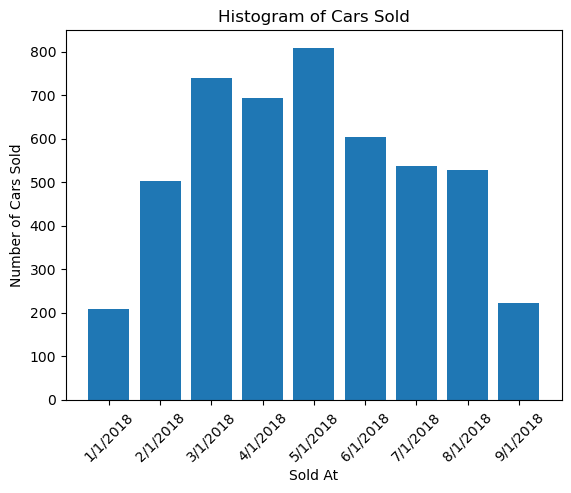

In [20]:
plt.bar(sold_at_counts.index, sold_at_counts.values)
plt.xlabel('Sold At')
plt.ylabel('Number of Cars Sold')
plt.title('Histogram of Cars Sold')
plt.xticks(rotation=45) 
plt.show()

In [21]:
registration_counts = df['registration_date'].value_counts().sort_index()

In [22]:
df["registration_date"] = pd.to_datetime(df["registration_date"])

In [23]:
fixed_date = pd.to_datetime('1/1/2018')
df["age"] = (fixed_date.year - df["registration_date"].dt.year) * 12 + (fixed_date.month - df["registration_date"].dt.month)

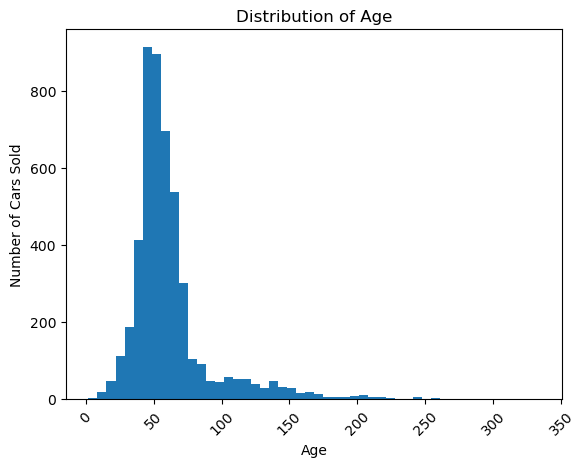

In [24]:
age_distribution = df['age'].value_counts().sort_index()
plt.hist(df['age'], bins=50)
plt.xlabel('Age')
plt.ylabel('Number of Cars Sold')
plt.title('Distribution of Age')
plt.xticks(rotation=45)
plt.show()

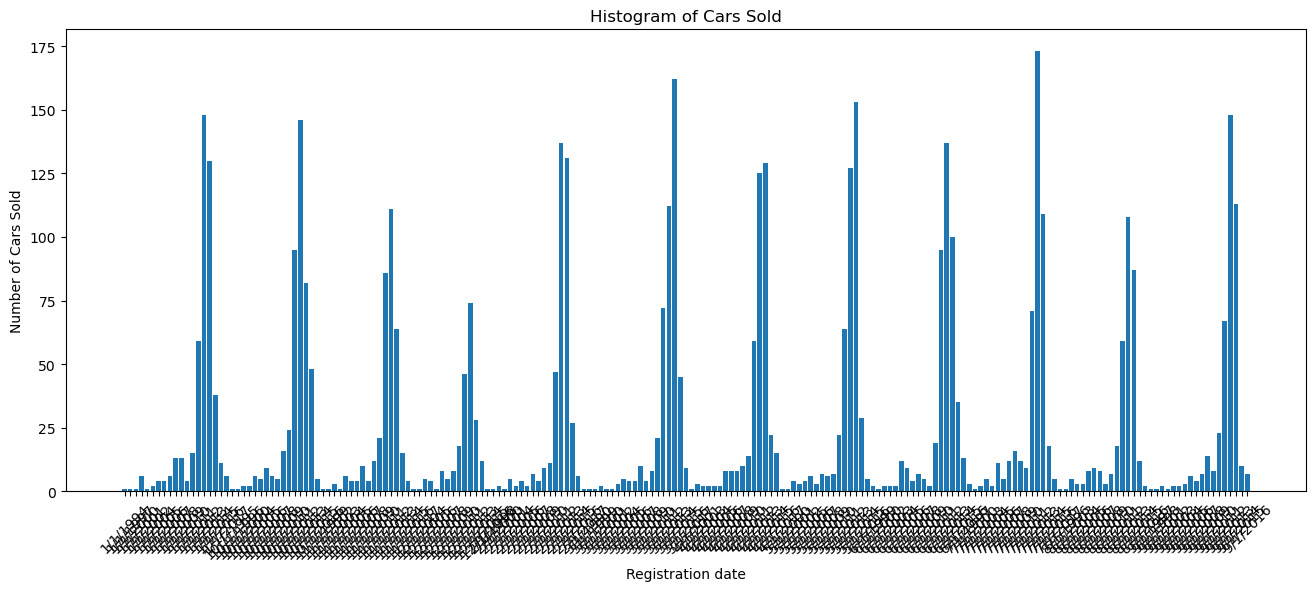

In [25]:
df = df.sort_values(by='registration_date').reset_index()
plt.figure(figsize=(16, 6))
plt.bar(registration_counts.index, registration_counts.values)
plt.xlabel('Registration date')
plt.ylabel('Number of Cars Sold')
plt.title('Histogram of Cars Sold')
plt.xticks(rotation=45)
plt.show()

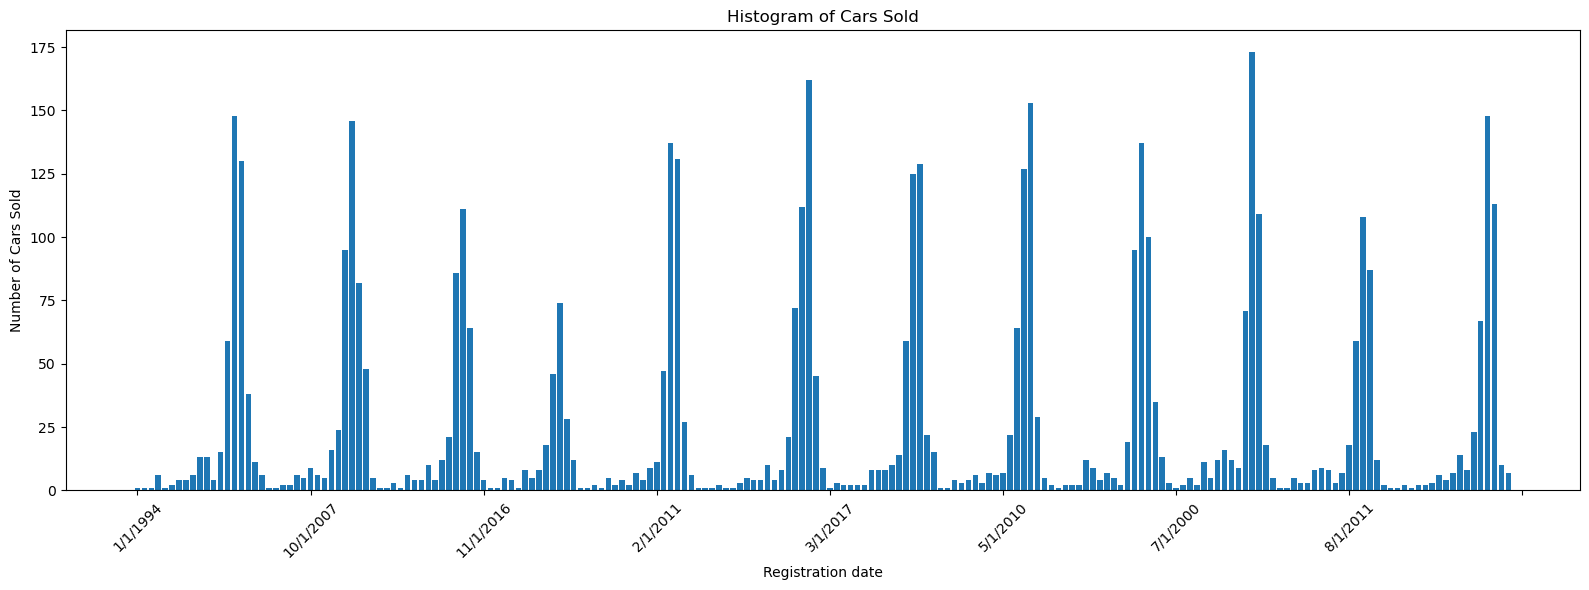

In [26]:
plt.figure(figsize=(16, 6))
plt.bar(registration_counts.index, registration_counts.values)
plt.xlabel('Registration date')
plt.ylabel('Number of Cars Sold')
plt.title('Histogram of Cars Sold')

# Configuration pour afficher seulement quelques étiquettes sur l'axe des x
max_num_labels = 10  # Choisissez le nombre maximum d'étiquettes à afficher
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=max_num_labels))

plt.xticks(rotation=45)
plt.tight_layout()  # Pour éviter que les étiquettes se chevauchent
plt.show()

In [27]:
corr_df = df[["mileage", "engine_power", "age", "price"]]

In [28]:
correlation = corr_df.corr()

In [29]:
correlation

,mileage,engine_power,age,price
mileage,1.000000,-0.050116,0.510004,-0.409564
engine_power,-0.050116,1.000000,-0.082636,0.638989
age,0.510004,-0.082636,1.000000,-0.448923
price,-0.409564,0.638989,-0.448923,1.000000


<Axes: >

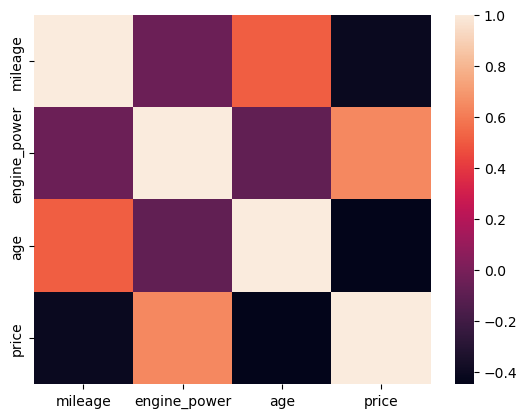

In [30]:
sns.heatmap(correlation)

In [31]:
numerical_feats = ['mileage', 'engine_power', 'age']
categorical_feats = ['model_key', 'fuel', 'paint_color', 'car_type']
boolean_feats = ['feature_1','feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

In [32]:
stand_scaler = StandardScaler()
encoder = LabelEncoder()
dummifier = OneHotEncoder(drop='first')

In [33]:
numerical_pipeline = ColumnTransformer(
    [(
        "standard",
        StandardScaler(),
        numerical_feats
     )]
)

In [34]:
categorical_pipeline = ColumnTransformer(
    [
        (
            'dummification',
            OneHotEncoder(),
            categorical_feats        )
    ]
)



In [35]:
boolean_pipeline = ColumnTransformer(
    [
        (
            "encoding",
            LabelEncoder(),
            boolean_feats
        )
    ]
)

In [36]:
df_test = df_raw.copy()

In [37]:
df_test_counts = df_test['model_key'].value_counts()
df_test_trunc = df_test[df_test['model_key'].isin(df_test_counts[df_test_counts > 1].index)]

In [38]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(df_test_trunc['price'], df_test['price'], equal_var=False)

print("T-test pour la colonne 'price':")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Différence statistiquement significative dans les moyennes\n")
else:
    print("Pas de différence statistiquement significative dans les moyennes\n")


T-test pour la colonne 'price':
T-statistic: -0.11057626011275971
P-value: 0.9119546680317866
Pas de différence statistiquement significative dans les moyennes



In [39]:
from scipy.stats import levene

levene_statistic, p_value = levene(df_test_trunc['price'], df_test['price'])

print("Statis pour la colonne 'price':")
print(f"Levene stat: {levene_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Différence statistiquement significative dans les écart-types\n")
else:
    print("Pas de différence statistiquement significative dans les écart-types\n")

Statis pour la colonne 'price':
Levene stat: 0.019484686430782598
P-value: 0.8889887778099471
Pas de différence statistiquement significative dans les écart-types



In [40]:
df_counts = df['model_key'].value_counts()
df = df[df['model_key'].isin(df_counts[df_counts > 1].index)]

In [41]:
X = df.drop(columns=['price', 'sold_at', 'maker_key', 'registration_date'])

In [42]:
X['model_key'].value_counts().tail(20)

125                  5
430 Gran Coupé       4
523                  4
216 Gran Tourer      4
435                  4
325 Gran Turismo     4
135                  4
X5 M50               3
335 Gran Turismo     3
220                  3
M235                 3
330 Gran Turismo     3
216 Active Tourer    3
M4                   2
430                  2
750                  2
123                  2
535 Gran Turismo     2
650                  2
425                  2
Name: model_key, dtype: int64

In [43]:
y = df['price']

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=43)

In [50]:
preprocessor = ColumnTransformer([
    ('numeric', stand_scaler, numerical_feats),
    ('categorical', dummifier, categorical_feats)
    ]
)

In [47]:
# for model in models:
#     start = time.time()
#     pipeline = make_pipeline(preprocessor, model)
#     pipeline.fit_transform(X_train,y_train)
#     end = time.time()
#     print(type(model).__name__)
#     print("")
#     print("Time : {:.4f} sec".format(end-start))
#     print("Train Score : {:.3f} , Test Score : {:.3f}".format(pipe.score(X_train,y_train), pipe.score(X_test,y_test)))
#     print("Root mean square error : {:.0f}".format(mean_squared_error(y_test,pipe.predict(X_test))**(1/2)))
#     print("")
#     print(50*"*")

In [54]:
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    RandomForestRegressor(n_estimators=100, random_state=43),
    xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    
]

In [48]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

ValueError: Found unknown categories ['M4'] in column 0 during transform

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=43)

In [ ]:
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=43)

In [ ]:
y_train_pred = regressor.predict(X_train)

In [ ]:
y_train_pred

array([16734., 38081.,  9783., ...,  8169., 10253.,  4940.])

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
y_test_pred[0:5]

array([11376., 18823., 17073.,  1485., 16486.])

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")


Mean Squared Error: 34474582.67
Mean Absolute Error: 2139.37
Root Mean Squared Error: 5871.51
R-squared: 0.67


In [ ]:
feature_importance["coefficients"] = feature_importance["coefficients"].abs()

# Visualize ranked features using seaborn
sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance.sort_values(by="coefficients", ascending=False), 
            kind="bar",
            aspect=16/9) # Resize graph